In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 11.2 MB/s  0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 31.7 MB/s  0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
ERROR: Operation cancelled by user
^C


In [2]:
import os
import kagglehub


###Importing Data set from Kaggle
# Download Kaggle dataset (runs only the first time, afterwards it uses cache)
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Kaggle dataset downloaded to:", path)
print("Exists? ->", os.path.exists(path))
print("Subfolders in downloaded path:", os.listdir(path))

# For this Kaggle dataset, the actual images are inside a "chest_xray" folder
# inside the downloaded path. So:
DATASET_DIR = os.path.join(path, "chest_xray")

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR   = os.path.join(DATASET_DIR, "val")
TEST_DIR  = os.path.join(DATASET_DIR, "test")

print("DATASET_DIR:", os.path.abspath(DATASET_DIR))
print("Exists? ->", os.path.exists(DATASET_DIR))
print("Train subfolders:", os.listdir(TRAIN_DIR))
print("Val subfolders:", os.listdir(VAL_DIR))
print("Test subfolders:", os.listdir(TEST_DIR))


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Kaggle dataset downloaded to: /kaggle/input/chest-xray-pneumonia
Exists? -> True
Subfolders in downloaded path: ['chest_xray']
DATASET_DIR: /kaggle/input/chest-xray-pneumonia/chest_xray
Exists? -> True
Train subfolders: ['PNEUMONIA', 'NORMAL']
Val subfolders: ['PNEUMONIA', 'NORMAL']
Test subfolders: ['PNEUMONIA', 'NORMAL']


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Sample batch X shape: (32, 224, 224, 3)
Sample batch y shape: (32,)


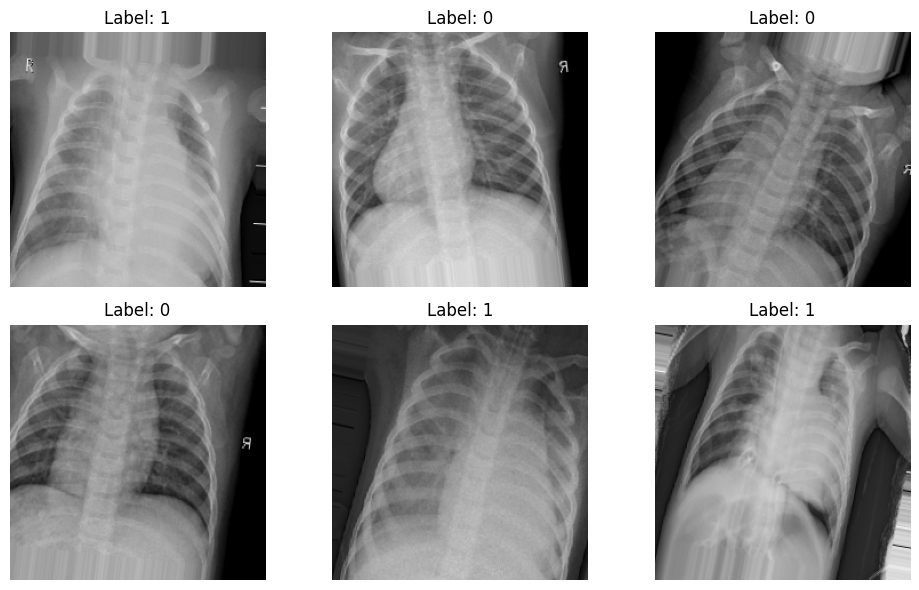

In [3]:
# 01_preprocessing_and_augmentation.py

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

# ===== DATA GENERATORS =====
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

print("Class indices:", train_generator.class_indices)

# ===== CHECK A BATCH & VISUALIZE =====
x_batch, y_batch = next(train_generator)
print("Sample batch X shape:", x_batch.shape)
print("Sample batch y shape:", y_batch.shape)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {int(y_batch[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [4]:
##custom CNN model

#  HYPERPARAMETERS
OPTIMIZER_NAME = "adam"      #  "adam", "sgd", or anything else
LEARNING_RATE = 0.001
EPOCHS = 5                 # adjust this to change number of epochs
DROPOUT_RATE = 0.5
IMAGE_SIZE = (224, 224)

# ===== OPTIMIZER =====
if OPTIMIZER_NAME == "adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
elif OPTIMIZER_NAME == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)
else:
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

# ===== CUSTOM CNN =====
def build_custom_cnn(input_shape=(224, 224, 3), dropout_rate=0.5):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu",
                               padding="same", input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])
    return model

model = build_custom_cnn(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    dropout_rate=DROPOUT_RATE
)
model.compile(optimizer=optimizer, loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

# ===== TRAIN =====
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,769 (98.36 MB)

 Trainable params: 25,784,321 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 163s 924ms/step - accuracy: 0.7924 - loss: 5.1031 - val_accuracy: 0.5000 - val_loss: 14.2523
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 724ms/step - accuracy: 0.8644 - loss: 0.3374 - val_accuracy: 0.5625 - val_loss: 18.8273
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 699ms/step - accuracy: 0.8861 - loss: 0.3105 - val_accuracy: 0.5625 - val_loss: 4.8836
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 671ms/step - accuracy: 0.8949 - loss: 0.2545 - val_accuracy: 0.5000 - val_loss: 11.1810
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 662ms/step - accuracy: 0.8937 - loss: 0.2701 - val_accuracy: 0.6875 - val_loss: 0.7436


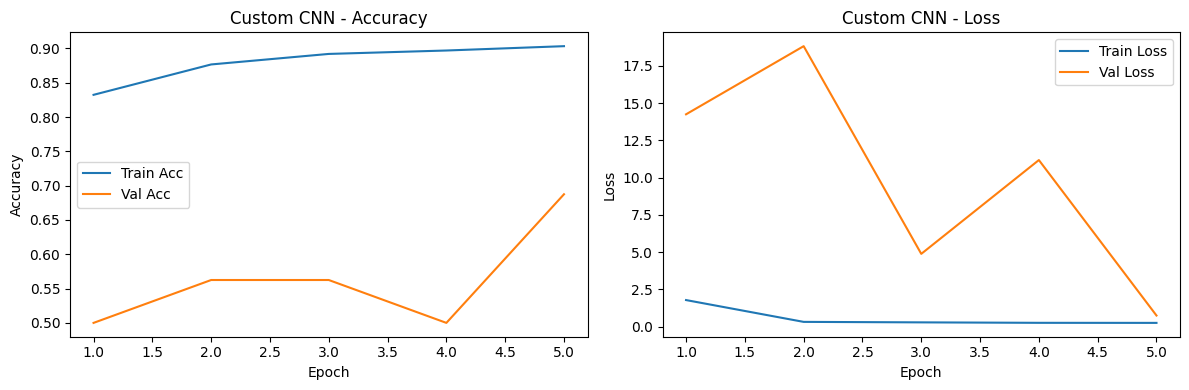

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step - accuracy: 0.8152 - loss: 0.5928
Test Loss: 0.4470
Test Accuracy: 0.8446
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step
Confusion Matrix:
 [[182  52]
 [ 45 345]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.80      0.78      0.79       234
   PNEUMONIA       0.87      0.88      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624

ROC-AUC: 0.8987


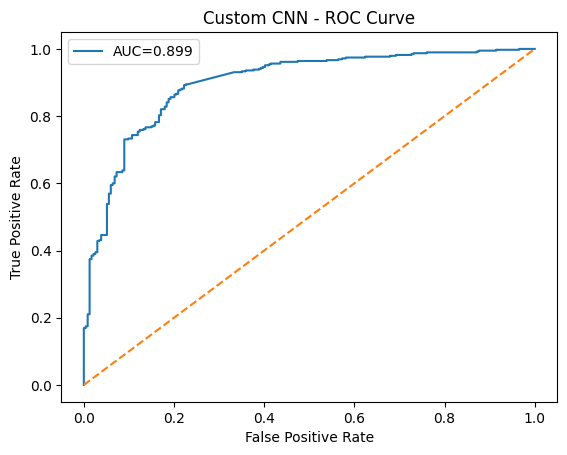

Saved as custom_cnn_model.h5


In [5]:
# ===== PLOT CURVES =====
def plot_curves(history, title_prefix="Custom CNN"):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.title(f"{title_prefix} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves(history, "Custom CNN")

# ===== TEST EVALUATION =====
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

y_true = test_generator.classes
y_prob = model.predict(test_generator).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred, target_names=list(test_generator.class_indices.keys())
))

try:
    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"ROC-AUC: {roc_auc:.4f}")
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Custom CNN - ROC Curve")
    plt.legend()
    plt.show()
except Exception as e:
    print("ROC not computed:", e)

model.save("custom_cnn_model.h5")
print("Saved as custom_cnn_model.h5")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

==== Training VGG16 ====
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 741ms/step - accuracy: 0.7201 - loss: 0.6008 - val_accuracy: 0.5000 - val_loss: 0.7502
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 684ms/step - accuracy: 0.7473 - loss: 0.5349 - val_accuracy: 0.5000 - val_loss: 0.6671
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 686ms/step - accuracy: 0.7615 - loss: 0.4932 - val_accuracy: 0.5625 - val_loss: 0.6603
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 690ms/step - accuracy: 0.8015 - loss: 0.4286 - val_accuracy: 0.6875 - val_loss: 0.5866
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 693ms/step - accuracy: 0.7963 - loss: 0.4128 - val_accuracy: 0.6875 - val_loss: 0.5992


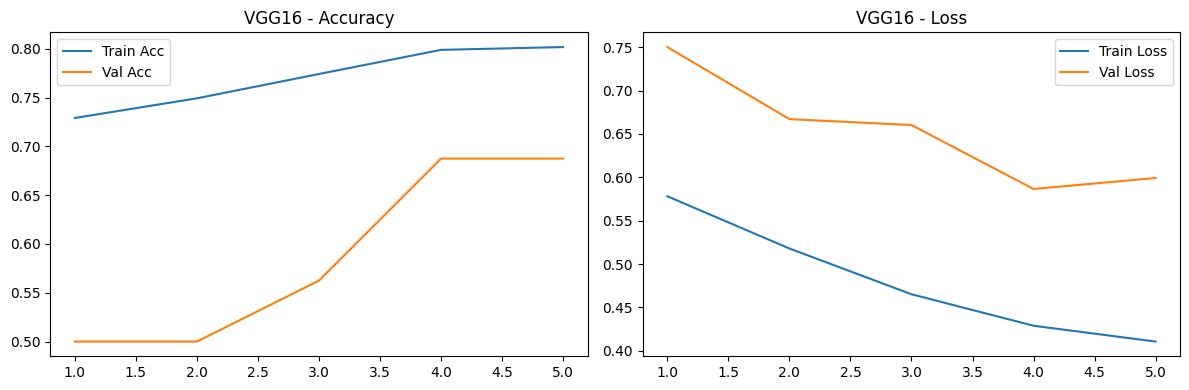

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - accuracy: 0.6956 - loss: 0.6090
VGG16 Test Loss: 0.4435
VGG16 Test Accuracy: 0.8077
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step


VGG16 Confusion Matrix:
 [[128 106]
 [ 14 376]]

VGG16 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.55      0.68       234
   PNEUMONIA       0.78      0.96      0.86       390

    accuracy                           0.81       624
   macro avg       0.84      0.76      0.77       624
weighted avg       0.83      0.81      0.79       624

VGG16 saved as vgg16_model.h5
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

==== Training VGG19 ====
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 700ms/step - accuracy: 0.6480 - loss: 0.6700 - val_accuracy: 0.5000 - val_loss: 0.7564
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 695ms/step - accuracy: 0.7543 - loss: 0.5297 - val_accuracy: 0.5625 - val_loss: 0.6486
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 701ms/step - accuracy: 0.7721 - loss: 0.4850 - val_accuracy: 0.5625 - val_loss: 0.6367
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 696ms/step - accuracy: 0.7928 - loss: 0.4458 - val_

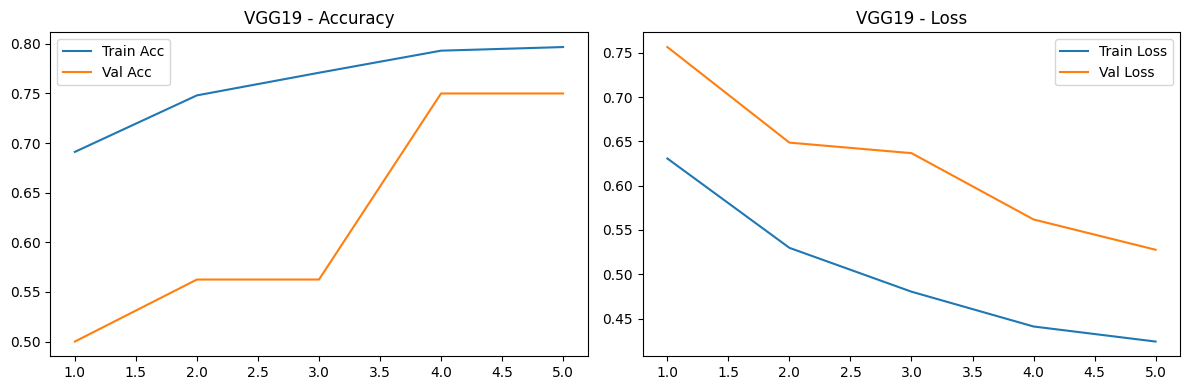

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.6136 - loss: 0.6566
VGG19 Test Loss: 0.4886
VGG19 Test Accuracy: 0.7676
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step


VGG19 Confusion Matrix:
 [[114 120]
 [ 25 365]]

VGG19 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.82      0.49      0.61       234
   PNEUMONIA       0.75      0.94      0.83       390

    accuracy                           0.77       624
   macro avg       0.79      0.71      0.72       624
weighted avg       0.78      0.77      0.75       624

VGG19 saved as vgg19_model.h5

==== Test Accuracy Comparison (VGG) ====
VGG16: 0.8077
VGG19: 0.7676


In [6]:
#  VGG16 & VGG19 transfer learning

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

## Hyper parameters
EPOCHS = 5  ## adjust this
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5


def build_transfer_model(base_model, dropout_rate=0.5):
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
    return model


def train_and_evaluate(model_name="VGG16"):
    if model_name == "VGG16":
        base = tf.keras.applications.VGG16(
            weights="imagenet",
            include_top=False,
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
        )
    else:
        base = tf.keras.applications.VGG19(
            weights="imagenet",
            include_top=False,
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
        )

    for layer in base.layers:
        layer.trainable = False

    model = build_transfer_model(base, dropout_rate=DROPOUT_RATE)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    print(f"\n==== Training {model_name} ====")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
    )

    # plots
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.title(f"{model_name} - Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.title(f"{model_name} - Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # test eval
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{model_name} Test Loss: {test_loss:.4f}")
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")

    y_true = test_generator.classes
    y_prob = model.predict(test_generator).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    print(f"{model_name} Confusion Matrix:\n", cm)
    print(f"\n{model_name} Classification Report:")
    print(classification_report(
        y_true, y_pred, target_names=list(test_generator.class_indices.keys())
    ))

    filename = f"{model_name.lower()}_model.h5"
    model.save(filename)
    print(f"{model_name} saved as {filename}")
    return test_acc


acc_vgg16 = train_and_evaluate("VGG16")
acc_vgg19 = train_and_evaluate("VGG19")

print("\n==== Test Accuracy Comparison (VGG) ====")
print(f"VGG16: {acc_vgg16:.4f}")
print(f"VGG19: {acc_vgg19:.4f}")


In [7]:
!pip install gradio
import gradio
print(gradio.__version__)


5.50.0


In [10]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd

# Make sure these files exist in the current folder
model_files = {
    "Custom CNN": "custom_cnn_model.h5",
    "VGG16": "vgg16_model.h5",
    "VGG19": "vgg19_model.h5",
    "ResNet50": "resnet50_model.h5"
}

results = []
all_conf_mats = {}
all_class_reports = {}

# true labels (same for all models)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
print("Class order in generator:", class_names)

for model_name, filename in model_files.items():
    print(f"\n==================== {model_name} ====================")
    print(f"Loading model from: {filename}")
    model = tf.keras.models.load_model(filename)

    # --- Test loss & accuracy ---
    test_generator.reset()
    loss, acc = model.evaluate(test_generator, verbose=0)
    print(f"{model_name} - Test Loss: {loss:.4f}")
    print(f"{model_name} - Test Accuracy: {acc:.4f}")

    # --- Predictions for confusion matrix & ROC-AUC ---
    test_generator.reset()
    y_prob = model.predict(test_generator, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification report (precision, recall, F1)
    cr = classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4
    )
    print("\nClassification Report:\n", cr)

    # ROC–AUC
    try:
        auc = roc_auc_score(y_true, y_prob)
        print(f"ROC–AUC: {auc:.4f}")
    except Exception as e:
        auc = np.nan
        print("ROC–AUC could not be computed:", e)

    # Store for summary table
    results.append({
        "Model": model_name,
        "Test Loss": loss,
        "Test Accuracy": acc,
        "ROC–AUC": auc
    })
    all_conf_mats[model_name] = cm
    all_class_reports[model_name] = cr

# ==== Summary Table ====
df_results = pd.DataFrame(results)
print("\n\n===== Overall Model Comparison =====")
print(df_results.sort_values(by="Test Accuracy", ascending=False))



Class order in generator: ['NORMAL', 'PNEUMONIA']

==================== Custom CNN ====================
Loading model from: custom_cnn_model.h5


Custom CNN - Test Loss: 0.4470
Custom CNN - Test Accuracy: 0.8446


Confusion Matrix:
 [[182  52]
 [ 45 345]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.8018    0.7778    0.7896       234
   PNEUMONIA     0.8690    0.8846    0.8767       390

    accuracy                         0.8446       624
   macro avg     0.8354    0.8312    0.8332       624
weighted avg     0.8438    0.8446    0.8441       624

ROC–AUC: 0.8987

==================== VGG16 ====================
Loading model from: vgg16_model.h5
VGG16 - Test Loss: 0.4435
VGG16 - Test Accuracy: 0.8077
Confusion Matrix:
 [[128 106]
 [ 14 376]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.9014    0.5470    0.6809       234
   PNEUMONIA     0.7801    0.9641    0.8624       390

    accuracy                         0.8077       624
   macro avg     0.8407    0.7556    0.7716       624
weighted avg     0.8256    0.8077    0.7943       624

ROC–AUC: 0.9088

==================== VGG19 ============

VGG19 - Test Loss: 0.4886
VGG19 - Test Accuracy: 0.7676
Confusion Matrix:
 [[114 120]
 [ 25 365]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.8201    0.4872    0.6113       234
   PNEUMONIA     0.7526    0.9359    0.8343       390

    accuracy                         0.7676       624
   macro avg     0.7864    0.7115    0.7228       624
weighted avg     0.7779    0.7676    0.7507       624

ROC–AUC: 0.8571

==================== ResNet50 ====================
Loading model from: resnet50_model.h5


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'resnet50_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [11]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd

# Make sure these files exist in the current folder
model_files = {
    "Custom CNN": "custom_cnn_model.h5",
    "VGG16": "vgg16_model.h5",
    "VGG19": "vgg19_model.h5"
}

results = []
all_conf_mats = {}
all_class_reports = {}

# true labels (same for all models)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
print("Class order in generator:", class_names)

for model_name, filename in model_files.items():
    print(f"\n==================== {model_name} ====================")
    print(f"Loading model from: {filename}")
    model = tf.keras.models.load_model(filename)

    # --- Test loss & accuracy ---
    test_generator.reset()
    loss, acc = model.evaluate(test_generator, verbose=0)
    print(f"{model_name} - Test Loss: {loss:.4f}")
    print(f"{model_name} - Test Accuracy: {acc:.4f}")

    # --- Predictions for confusion matrix & ROC-AUC ---
    test_generator.reset()
    y_prob = model.predict(test_generator, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification report (precision, recall, F1)
    cr = classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4
    )
    print("\nClassification Report:\n", cr)

    # ROC–AUC
    try:
        auc = roc_auc_score(y_true, y_prob)
        print(f"ROC–AUC: {auc:.4f}")
    except Exception as e:
        auc = np.nan
        print("ROC–AUC could not be computed:", e)

    # Store for summary table
    results.append({
        "Model": model_name,
        "Test Loss": loss,
        "Test Accuracy": acc,
        "ROC–AUC": auc
    })
    all_conf_mats[model_name] = cm
    all_class_reports[model_name] = cr

# ==== Summary Table ====
df_results = pd.DataFrame(results)
print("\n\n===== Overall Model Comparison =====")
print(df_results.sort_values(by="Test Accuracy", ascending=False))

Class order in generator: ['NORMAL', 'PNEUMONIA']

==================== Custom CNN ====================
Loading model from: custom_cnn_model.h5


Custom CNN - Test Loss: 0.4470
Custom CNN - Test Accuracy: 0.8446


Confusion Matrix:
 [[182  52]
 [ 45 345]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.8018    0.7778    0.7896       234
   PNEUMONIA     0.8690    0.8846    0.8767       390

    accuracy                         0.8446       624
   macro avg     0.8354    0.8312    0.8332       624
weighted avg     0.8438    0.8446    0.8441       624

ROC–AUC: 0.8987

==================== VGG16 ====================
Loading model from: vgg16_model.h5
VGG16 - Test Loss: 0.4435
VGG16 - Test Accuracy: 0.8077
Confusion Matrix:
 [[128 106]
 [ 14 376]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.9014    0.5470    0.6809       234
   PNEUMONIA     0.7801    0.9641    0.8624       390

    accuracy                         0.8077       624
   macro avg     0.8407    0.7556    0.7716       624
weighted avg     0.8256    0.8077    0.7943       624

ROC–AUC: 0.9088

==================== VGG19 ============

VGG19 - Test Loss: 0.4886
VGG19 - Test Accuracy: 0.7676
Confusion Matrix:
 [[114 120]
 [ 25 365]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.8201    0.4872    0.6113       234
   PNEUMONIA     0.7526    0.9359    0.8343       390

    accuracy                         0.7676       624
   macro avg     0.7864    0.7115    0.7228       624
weighted avg     0.7779    0.7676    0.7507       624

ROC–AUC: 0.8571


===== Overall Model Comparison =====
        Model  Test Loss  Test Accuracy   ROC–AUC
0  Custom CNN   0.446974       0.844551  0.898685
1       VGG16   0.443519       0.807692  0.908755
2       VGG19   0.488581       0.767628  0.857079


In [12]:
import os
print(os.listdir())


['.config', 'vgg16_model.h5', 'custom_cnn_model.h5', 'vgg19_model.h5', 'sample_data']


In [13]:
MODEL_PATH = "resnet50_model.h5"
MODEL_PATH = "vgg19_model.h5"
MODEL_PATH = "custom_cnn_model.h5"
MODEL_PATH = "vgg16_model.h5"


In [14]:
import numpy as np
from PIL import Image
import tensorflow as tf
import gradio as gr

print("TensorFlow version:", tf.__version__)
print("Gradio version:", gr.__version__)

#  SELECT YOUR MODEL HERE
MODEL_PATH = "vgg16_model.h5"   #  "custom_cnn_model.h5" OR "vgg19_model.h5" OR "resnet50_model.h5"

IMAGE_SIZE = (224, 224)
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]


# Load model
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f" Loaded model from: {MODEL_PATH}")
except Exception as e:
    print(" Error loading model:")
    print(e)
    raise


def preprocess_image(image: Image.Image):
    image = image.convert("RGB")
    image = image.resize(IMAGE_SIZE)
    arr = tf.keras.preprocessing.image.img_to_array(image)
    arr = arr / 255.0
    arr = np.expand_dims(arr, axis=0)
    return arr


def predict(image: Image.Image):
    if image is None:
        return "No image uploaded", 0.0

    x = preprocess_image(image)
    prob = float(model.predict(x)[0][0])

    if prob >= 0.5:
        label = CLASS_NAMES[1]
        confidence = prob
    else:
        label = CLASS_NAMES[0]
        confidence = 1.0 - prob

    return f"Prediction: {label}", confidence


with gr.Blocks() as demo:
    gr.Markdown("## Chest X-Ray Classifier (Normal vs Pneumonia)")

    with gr.Row():
        img_input = gr.Image(type="pil", label="Upload Chest X-Ray")
        output_label = gr.Textbox(label="Prediction")
        output_conf = gr.Number(label="Confidence")

    submit_btn = gr.Button("Classify")
    submit_btn.click(fn=predict, inputs=img_input, outputs=[output_label, output_conf])

demo.launch(share=True)


TensorFlow version: 2.19.0
Gradio version: 5.50.0


 Loaded model from: vgg16_model.h5
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://89da8b15b12a3aeeae.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


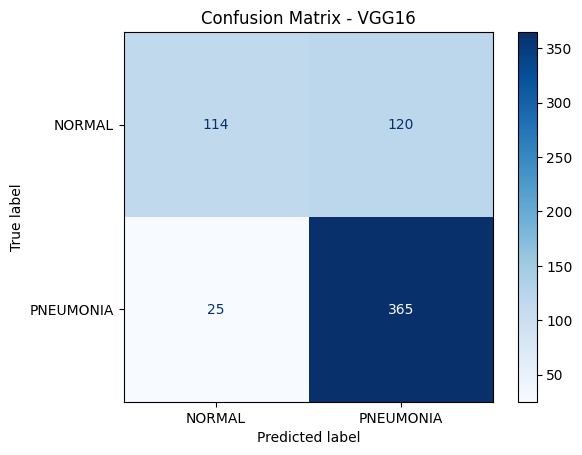

In [15]:
## confusion matrix ##

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

## b. VGG16
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_generator.class_indices.keys())
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - VGG16")  # change per model
plt.show()



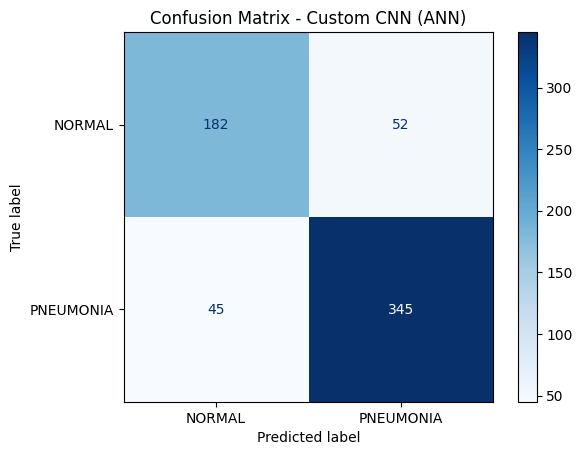

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get the confusion matrix for the Custom CNN model
cm_custom_cnn = all_conf_mats['Custom CNN']

# Get class labels from test_generator
display_labels = list(test_generator.class_indices.keys())

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_custom_cnn,
                              display_labels=display_labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Custom CNN (ANN)")
plt.show()